In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import gensim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz


--2024-05-02 09:52:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.51, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G   150MB/s    in 8.8s    

2024-05-02 09:52:36 (138 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [4]:
!unzip "/content/drive/MyDrive/Dataset of Arabic Spam and Ham Tweets.zip"

Archive:  /content/drive/MyDrive/Dataset of Arabic Spam and Ham Tweets.zip
  inflating: Dataset of Arabic Spam and Ham Tweets/Dataset of Arabic Spam and Ham Tweets.xlsx  
  inflating: Dataset of Arabic Spam and Ham Tweets/Augmented_SpamHamTweets.xlsx  


In [5]:
import pandas as pd
data_path = '/content/Dataset of Arabic Spam and Ham Tweets/Augmented_SpamHamTweets.xlsx'  # Update this path
data = pd.read_excel(data_path)

In [6]:
data.head()

,Tweet Text,Cleaned Text,Label,Date,Time,Date Time
0,عسكريون إسرائيليون متقاعدون يطالبون بايدن بعدم...,عسكريون اسرائيليون متقاعدون يطالبون بايدن بعدم...,Ham,2021-03-02 00:00:00,10:38:56,Tue Mar 02 10:38:56 +0000 2021
1,دراسة دولية زيادة أعداد الأشخاص الراغبين في تل...,دراسه دوليه زياده اعداد الاشخاص الراغبين في تل...,Ham,2021-03-02 00:00:00,10:28:53,Tue Mar 02 10:28:53 +0000 2021
2,مصادر عسكرية القوات السودانية تقترب من منطقة ب...,مصادر عسكريه القوات السودانيه تقترب من منطقه ب...,Ham,2021-03-02 00:00:00,10:24:15,Tue Mar 02 10:24:15 +0000 2021
3,المحل العسكري والاستراتيجي حنفي عبداله السودان...,المحل العسكري والاستراتيجي حنفي عبداله السودان...,Ham,2021-03-02 00:00:00,10:19:14,Tue Mar 02 10:19:14 +0000 2021
4,تخط منغوليا الداخلية لإغلاق جميع عمليات تعدين ...,تخط منغوليا الداخليه لاغلاق جميع عمليات تعدين ...,Ham,2021-03-02 00:00:00,10:18:15,Tue Mar 02 10:18:15 +0000 2021


In [7]:
# Load pre-trained fastText model
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False)


In [8]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Cleaned Text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(data['Cleaned Text'])

# Pad sequences to ensure uniform input size
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')


In [9]:
# Prepare embedding matrix
vocab_size = min(len(tokenizer.word_index) + 1, 10000)
embedding_matrix = np.zeros((vocab_size, 300))  # 300 is the dimensionality of fastText vectors
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vector = fasttext_model.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Word not in the pre-trained model will be all-zeros.


In [10]:
# Assuming 'data' is your DataFrame and it has a column named 'Label'
data['Label_conv'] = np.array([1 if label == 'Spam' else 0 for label in data['Label']])



In [11]:
data.groupby("Label_conv").count()

,Tweet Text,Cleaned Text,Label,Date,Time,Date Time
Label_conv,,,,,,
0,11030,11030,11030,11030,11030,11030
1,15128,15128,15128,15128,15128,15128


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Adjust the model architecture
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=300, weights=[fasttext_model.vectors[:10000]], input_length=50, trainable=False))
model.add(LSTM(32, return_sequences=True))  # Reduced complexity
model.add(Dropout(0.6))  # Increased dropout
model.add(LSTM(16))  # Further reduced complexity
model.add(Dense(1, activation='sigmoid'))

# Adjust optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Splitting the data
X_train, , y_train, y_val = train_test_split(padded_sequences, data['Label_conv'], test_size=0.2, random_state=42)
# Early Stopping to stop training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)
# Now, fit your model using X_train and y_train
history = model.fit(
    X_train,
    y_train,
    epochs=12,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)





Epoch 1/12
654/654 [==============================] - 17s 15ms/step - loss: 0.5896 - accuracy: 0.6741 - val_loss: 0.4053 - val_accuracy: 0.8448 - lr: 1.0000e-04
Epoch 2/12
654/654 [==============================] - 9s 13ms/step - loss: 0.3396 - accuracy: 0.8708 - val_loss: 0.2763 - val_accuracy: 0.8918 - lr: 1.0000e-04
Epoch 3/12
654/654 [==============================] - 8s 12ms/step - loss: 0.2598 - accuracy: 0.8986 - val_loss: 0.2306 - val_accuracy: 0.9056 - lr: 1.0000e-04
Epoch 4/12
654/654 [==============================] - 6s 9ms/step - loss: 0.2235 - accuracy: 0.9112 - val_loss: 0.2235 - val_accuracy: 0.9117 - lr: 1.0000e-04
Epoch 5/12
654/654 [==============================] - 7s 10ms/step - loss: 0.2008 - accuracy: 0.9206 - val_loss: 0.1854 - val_accuracy: 0.9239 - lr: 1.0000e-04
Epoch 6/12
654/654 [==============================] - 10s 15ms/step - loss: 0.1855 - accuracy: 0.9276 - val_loss: 0.1861 - val_accuracy: 0.9276 - lr: 1.0000e-04
Epoch 7/12
654/654 [===================

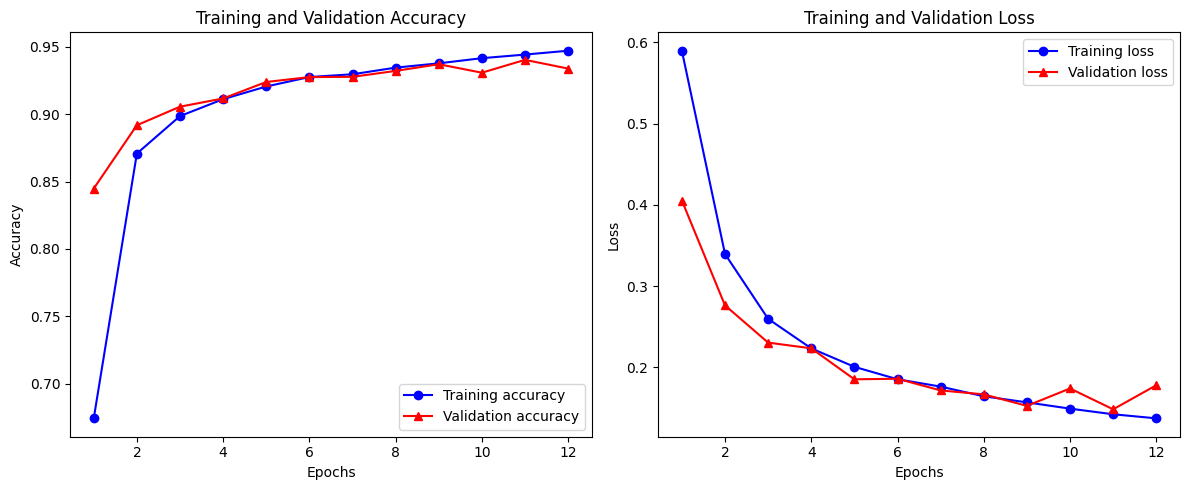

In [15]:
import matplotlib.pyplot as plt

# Extracting the history of training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


164/164 [==============================] - 3s 7ms/step


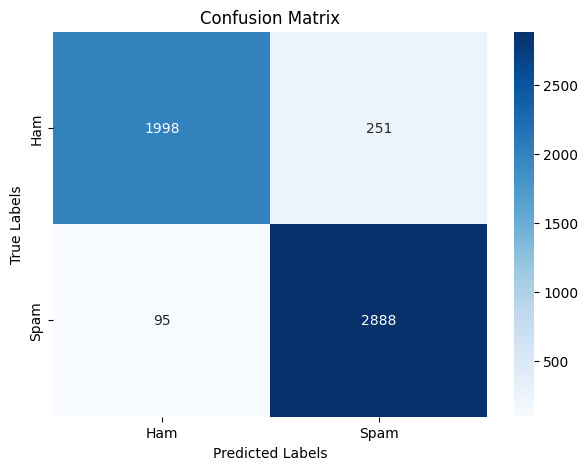

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
predictions = model.predict(X_val)
predicted_labels = [1 if x > 0.5 else 0 for x in predictions.flatten()]

# Compute confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


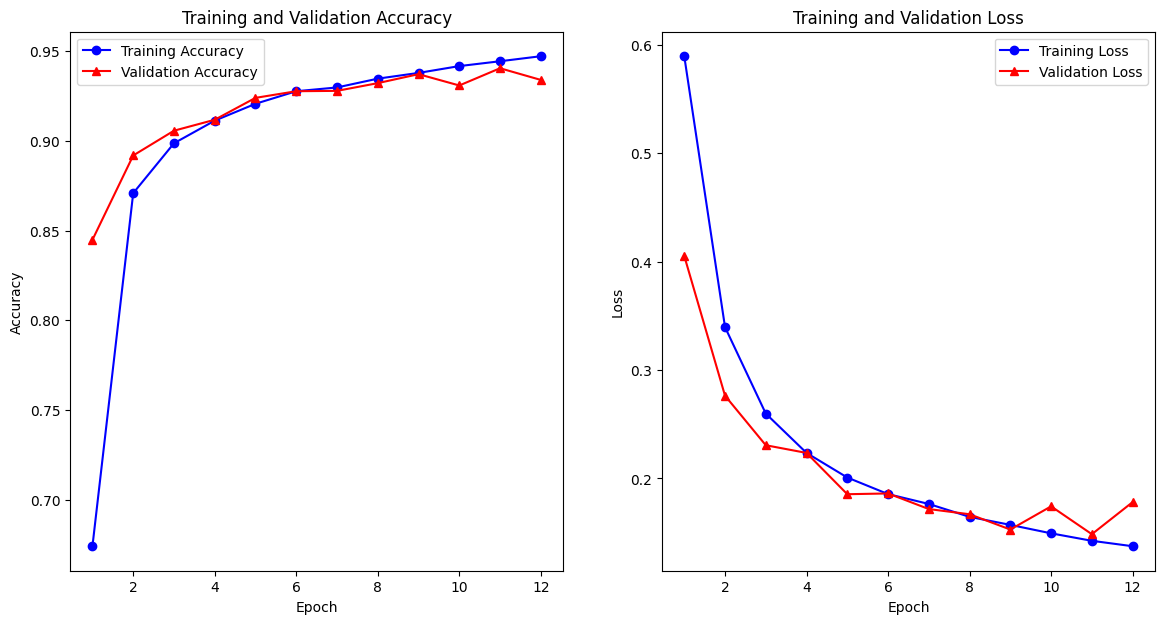

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, 13)
train_acc = [0.6741, 0.8708, 0.8986, 0.9112, 0.9206, 0.9276, 0.9297, 0.9346, 0.9378, 0.9416, 0.9443, 0.9471]
val_acc = [0.8448, 0.8918, 0.9056, 0.9117, 0.9239, 0.9276, 0.9278, 0.9321, 0.9371, 0.9308, 0.9404, 0.9339]
train_loss = [0.5896, 0.3396, 0.2598, 0.2235, 0.2008, 0.1855, 0.1764, 0.1645, 0.1571, 0.1493, 0.1424, 0.1374]
val_loss = [0.4053, 0.2763, 0.2306, 0.2235, 0.1854, 0.1861, 0.1717, 0.1669, 0.1528, 0.1742, 0.1485, 0.1781]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [21]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Save the entire model in the recommended Keras format.
model.save('my_model1.keras')
